# Twitter US Election Analysis

## 1. Creating a background environment

#### Load datasets, tweet texts and retweet IDs

In [2]:
import numpy as np
import json

file = open(r"/Users/Mughundhan/UIC/UIC Academics/SPRING 2018/TEXT ANALYTICS/Assignment1/shutdown.json")
js = json.load(file)

retweet_Id =[] #For retweet IDs.
for i in range(len(js)):
    if "retweeted_status" in js[i]:
        retweet_Id.append(js[i]["retweeted_status"]["user"]["screen_name"])

#Code chunk to load the Tweet Texts
tweet_data=[] #For tweet text
for i in range(len(js)):
    tweet_data.append(js[i]["text"])

## 2. Data Cleaning

#### Remove duplicate tweets

In [7]:
unique_Tweet=[]
unique_Tweet = np.unique(tweet_data)
unique_Tweet
print("The total number of Tweet Texts in the given dataset is:",len(tweet_data))
print("The total number of unique Tweet Texts shall be found using numpy and it is:",len(np.unique(tweet_data)))

('The total number of Tweet Texts in the given dataset is:', 5000)
('The total number of unique Tweet Texts shall be found using numpy and it is:', 919)


#### We can see that, there are 919 tweets remaining on excluding the duplicates.

#### Vectorize tweets using binary vectorization
1. Remove URLs
2. Remove Mentions
3. Rename Hashtags

In [9]:
import re #for regular expressions


##Renaming Hashtag using Regular Expressions
regexp_Htag = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)'
pattern_Htag = re.compile(regexp_Htag, re.UNICODE | re.IGNORECASE)

##Remove Mention using Regular Expressions
regexp_mention = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+[A-Za-z0-9_]+)'
pattern_mention = re.compile(regexp_mention, re.UNICODE | re.IGNORECASE)

##Remove URLs using Regular Expressions
regexp_URL = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern_URL = re.compile(regexp_URL, re.UNICODE | re.IGNORECASE)

def preprocess(text):
    temp = pattern_URL.sub('',text)                  #Removing URLs 
    temp = re.sub('\.(?!$)', '',temp)                #Removing periods to detect mentions
    temp = pattern_mention.sub('',temp)              #Removing Mentions
    temp = pattern_Htag.sub(r' hashtag_\1',temp)     #Replacing hashtags with hashtag_
    temp = temp.replace('\n','')                     
    temp = re.sub('^RT','',temp)                     
    temp = re.sub(':','',temp)                       
    temp = temp.lstrip(' ')                          
    return temp

preprocess_Tweet =[]
for i in range(len(unique_Tweet)):
    preprocess_Tweet.append(preprocess(unique_Tweet[i]))

preprocess_Tweet[:5]

## 3. Preliminary Analysis

#### Top five most popular retweet usernames

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(binary = True)
X = count.fit_transform(retweet_Id)
unique_Id = np.array(count.get_feature_names())

freq = X.sum(0).A1
order = freq.argsort()[::-1]
print(unique_Id[order[:5]])

[u'foxnews' u'sendougjones' u'peterdaou' u'thedailyedge' u'banditrandom']


#### Top five most popular Hashtags

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##Vectorize tweets using binary vectorization
bcount = CountVectorizer(binary = True)
Y = bcount.fit_transform(preprocess_Tweet)

hashtags = np.array(bcount.get_feature_names())
indices = [i for i,item in enumerate(hashtags) if "hashtag" in item]
freq = Y[:,indices].sum(0).A1
order = freq.argsort()[::-1]
new = hashtags[indices]
print(new[order[:5]])

[u'hashtag_shutdown' u'hashtag_trumpshutdown' u'hashtag_trump'
 u'hashtag_schumershutdown' u'hashtag_daca']


## 4. Map Document Term Matrix to 2-D Space

#### Plot using Binary Vectorization

Dimension (919, 2849) -> (919, 2)


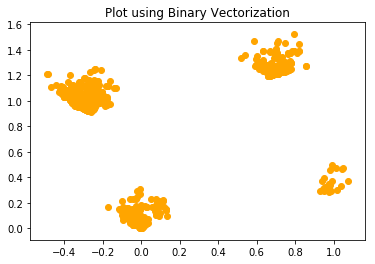

In [12]:
import matplotlib #for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline  
#to display it on the ipynb

from sklearn.decomposition import TruncatedSVD
vector1 = CountVectorizer(binary = True, stop_words = 'english')
fit = vector1.fit_transform(preprocess_Tweet)

lsa = TruncatedSVD(2)
fit2 = lsa.fit_transform(fit)

print("Dimension %s -> %s" % (fit.shape,fit2.shape))

plt.scatter(fit2[:,1],fit2[:,0], c='orange')
plt.title("Plot using Binary Vectorization")
plt.show()

#### Plot using Count Vectorization

Dimension (919, 2849) -> (919, 2)


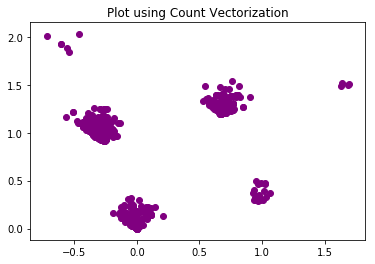

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import TruncatedSVD
vector1 = CountVectorizer(binary = False, stop_words = 'english')
fit = vector1.fit_transform(preprocess_Tweet)

lsa = TruncatedSVD(2)
fit2 = lsa.fit_transform(fit)

print("Dimension %s -> %s" % (fit.shape,fit2.shape))

plt.scatter(fit2[:,1],fit2[:,0],c='purple')
plt.title("Plot using Count Vectorization")
plt.show()

#### Plot using TF-IDF Vectorization

Dimension (919, 2849) -> (919, 2)


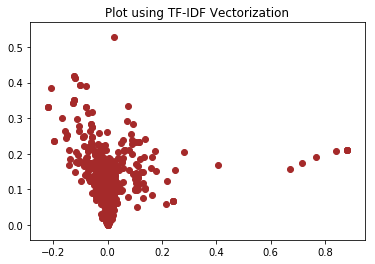

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import TruncatedSVD
vector1 = TfidfVectorizer(binary = False, stop_words = 'english')
fit = vector1.fit_transform(preprocess_Tweet)

lsa = TruncatedSVD(2)
fit2 = lsa.fit_transform(fit)

print("Dimension %s -> %s" % (fit.shape,fit2.shape))

plt.scatter(fit2[:,1],fit2[:,0],c='brown')
plt.title("Plot using TF-IDF Vectorization")
plt.show()

## 5. Co-occurrence Analysis

#### Identify which two hashtags appear together in the same tweet mostly

In [15]:
cocurr_count = CountVectorizer(binary = True, stop_words='english' )
Z = cocurr_count.fit_transform(preprocess_Tweet)

hashtag = np.array(cocurr_count.get_feature_names())

indices_n = [i for i,item in enumerate(hashtag) if "hashtag" in item]

Zc = (Z[:,indices_n].T * Z[:,indices_n])
Zc.setdiag(0) 

order = np.argwhere(Zc == np.amax(Zc))

new_Htag = hashtag[indices_n]

print(np.unique(new_Htag[order]).reshape(-1,2))

[[u'hashtag_shutdown' u'hashtag_trumpshutdown']]


#### Identify the 2nd most often occurring pair

In [16]:
Zx = Zc

for x in range(len(order)):
    i = order[x][0]
    j = order[x][1]
    Zx[i,j] = 0


new_order = np.argwhere(Zx == np.amax(Zx))

new_Htag = hashtag[indices_n]

print(np.unique(new_Htag[new_order]).reshape(-1,2))

[[u'hashtag_shutdown' u'hashtag_trump']]
